In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
import tssimul
import tspred
import tspred_qtl
import rnn_analysis

In [7]:
from sklearn.metrics import (mean_squared_error,
                             log_loss,
                             confusion_matrix)
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression,
                                  SGDClassifier,
                                  SGDRegressor)
from sklearn.decomposition import FastICA, PCA
from sklearn.ensemble import (RandomForestRegressor,
                              RandomForestClassifier)

In [8]:
burn_in = 50

# AR(1) 

Simulate samples

In [9]:
ar = [0.0868, 0.3667]
ma = [-0.1150, -0.4068]
sigma = .0112

In [10]:
simulation = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'n')
simulation_test = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'n')

In [11]:
simulation.shape, simulation_test.shape

((5000, 3, 1000), (5000, 3, 1000))

In [12]:
simulation_t = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 't', 4.5)
simulation_t_test = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 't', 4.5)

In [63]:
simulation_exp = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'exp')
simulation_exp_test = tssimul.simulate_arima(ar, ma, sigma, (5000, 1000), 'exp')

In [14]:
# np.savez_compressed('simulation', data=simulation)
# np.savez_compressed('simulation_test', data=simulation_test)

In [64]:
data = simulation_exp
data_test = simulation_exp_test

# Stochastic Volatility

Simulate samples

In [10]:
sv_beta = .98
sv_sigma = .168
sv_intercept = -3.926

In [11]:
sv, svvol = tssimul.simulate_sv(sv_beta, sv_sigma,
                                sv_intercept, (5000, 1000))
sv_test, svvol_test = tssimul.simulate_sv(sv_beta, sv_sigma,
                                          sv_intercept, (500, 1000))

In [12]:
stats.describe(sv.ravel())

DescribeResult(nobs=5000000, minmax=(-0.16251504124838245, 0.16889895057080634), mean=6.3666536513315898e-06, variance=0.00010975681166093846, skewness=0.008468034416795452, kurtosis=3.1227177163589674)

In [82]:
stats.describe(svvol.ravel())

DescribeResult(nobs=5000000, minmax=(0.018045324639038317, 1.1020478390646546), mean=0.15329274226257966, variance=0.0044917155658833405, skewness=1.4174405203109106, kurtosis=3.7752985793496885)

In [83]:
stats.describe(svvol.ravel() ** 2)

DescribeResult(nobs=5000000, minmax=(0.00032563374132828335, 1.214509439587075), mean=0.027990379497921915, variance=0.00080035720864075953, skewness=4.054450387095615, kurtosis=36.16007596911728)

In [84]:
stats.describe(svvol_test.ravel() ** 2)

DescribeResult(nobs=500000, minmax=(0.00035299657692129102, 0.89837317286388985), mean=0.027837523641173794, variance=0.00081043106975812117, skewness=4.255823225893204, kurtosis=39.43058636697476)

In [12]:
data = tssimul.simulate_arima_given_innov(ar, [], sv)
data_test = tssimul.simulate_arima_given_innov(ar, [], sv_test)

In [164]:
# np.savez_compressed(<file>, data=data, svvol=svvol)

# Regime-Switching Process

Simulate samples

In [11]:
rs_p0 = .8
rs_p00 = .9
rs_p10 = .2
rs_mu = [0, -.005]
rs_sigma = [.08, .3]
rs, rs_prob0, rs_regime = tssimul.simulate_rs(rs_p0, rs_p00,
                                              rs_p10, rs_mu,
                                              rs_sigma, (5000, 1000))
rs_test, rs_prob0_test, rs_regime_test = tssimul.simulate_rs(rs_p0,
                                                             rs_p00,
                                                             rs_p10,
                                                             rs_mu,
                                                             rs_sigma,
                                                             (500, 1000))

In [12]:
rs.shape, rs_prob0.shape, rs_regime.shape

((5000, 1000), (5000, 1000), (5000, 1000))

In [13]:
stats.describe(rs.ravel())

DescribeResult(nobs=5000000, minmax=(-0.10027182433879982, 0.1031418152339469), mean=-0.0016676499245161524, variance=0.00013972994882308483, skewness=-0.6644921381648347, kurtosis=3.8469821872161205)

In [13]:
np.sqrt(0.000139)

0.011789826122551595

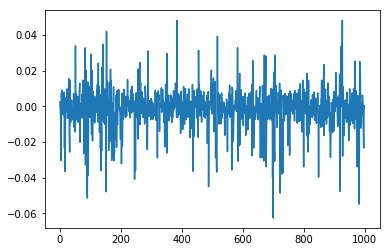

In [13]:
plt.plot(rs[75, :])

In [14]:
data = tssimul.simulate_arima_given_innov(ar, [], rs)
data_test = tssimul.simulate_arima_given_innov(ar, [], rs_test)

# Quantile Regression

In [15]:
sess = tf.Session()

In [16]:
simple_features = lambda x: x[:-1]

In [17]:
features_func = simple_features
targets_func = lambda x: x[1:]

In [18]:
symbols_qtl = {}
cell_qtl = {}
quantiles = [.05, .25, .5, .75, .95]

Either we use `features_func` and `targets_func` to compute `x` and `y`:

In [104]:
for i, qtl in enumerate(quantiles):
    symbols_qtl[qtl], cell_qtl[qtl] = (
        tspred_qtl.train_lstm(sess, data[:, 0, :] * 10,
                              features_func=features_func,
                              targets_func=targets_func,
                              quantiles=[qtl], burn_in=burn_in,
                              batch_size=50,
                              lr0=3e-3, lr_decay=(50, .99), n_iter=300,
                              num_units=10, variable_scope=f'rs_run{i}',
                              print_every=50))

Iter 0 Train loss 0.0179 Dev loss 0.0179
Iter 50 Train loss 0.0174 Dev loss 0.0174
Iter 100 Train loss 0.0174 Dev loss 0.0173
Iter 150 Train loss 0.0173 Dev loss 0.0172
Iter 200 Train loss 0.0171 Dev loss 0.0172
Iter 250 Train loss 0.0171 Dev loss 0.0172
Iter 0 Train loss 0.3545 Dev loss 0.3537
Iter 50 Train loss 0.2873 Dev loss 0.2860
Iter 100 Train loss 0.2180 Dev loss 0.2160
Iter 150 Train loss 0.1463 Dev loss 0.1451
Iter 200 Train loss 0.0864 Dev loss 0.0855
Iter 250 Train loss 0.0532 Dev loss 0.0528
Iter 0 Train loss 0.4299 Dev loss 0.4274
Iter 50 Train loss 0.2282 Dev loss 0.2242
Iter 100 Train loss 0.0729 Dev loss 0.0710
Iter 150 Train loss 0.0450 Dev loss 0.0441
Iter 200 Train loss 0.0450 Dev loss 0.0440
Iter 250 Train loss 0.0441 Dev loss 0.0440
Iter 0 Train loss 0.5563 Dev loss 0.5548
Iter 50 Train loss 0.2646 Dev loss 0.2594
Iter 100 Train loss 0.0581 Dev loss 0.0574
Iter 150 Train loss 0.0404 Dev loss 0.0403
Iter 200 Train loss 0.0399 Dev loss 0.0400
Iter 250 Train loss 0.0

Or we hand make them:

In [19]:
x = np.stack([data[:, 0, :-1] * 10,
              rs_regime[:, :-1]], axis=2)
y = data[:, 0, 1:] * 10
x.shape, y.shape

((5000, 999, 2), (5000, 999))

In [24]:
for i, qtl in enumerate(quantiles):
    symbols_qtl[qtl], cell_qtl[qtl] = (
        tspred_qtl.train_lstm(sess, x, y=y,
                              quantiles=[qtl], 
                              burn_in=burn_in,
                              batch_size=50,
                              lr0=3e-3, lr_decay=(50, .99), n_iter=300,
                              num_units=10, variable_scope=f'rs_run{i + 10}',
                              print_every=50))

Iter 0 Train loss 1.5250 Dev loss 1.5176
Iter 50 Train loss 0.9165 Dev loss 0.9051
Iter 100 Train loss 0.3849 Dev loss 0.3781
Iter 150 Train loss 0.0844 Dev loss 0.0793
Iter 200 Train loss 0.0222 Dev loss 0.0223
Iter 250 Train loss 0.0211 Dev loss 0.0209
Iter 0 Train loss 0.7959 Dev loss 0.7284
Iter 50 Train loss 0.0792 Dev loss 0.0778
Iter 100 Train loss 0.0654 Dev loss 0.0658
Iter 150 Train loss 0.0636 Dev loss 0.0640
Iter 200 Train loss 0.0624 Dev loss 0.0623
Iter 250 Train loss 0.0605 Dev loss 0.0607
Iter 0 Train loss 0.5997 Dev loss 0.5966
Iter 50 Train loss 0.4097 Dev loss 0.4062
Iter 100 Train loss 0.1910 Dev loss 0.1858
Iter 150 Train loss 0.0683 Dev loss 0.0682
Iter 200 Train loss 0.0632 Dev loss 0.0641
Iter 250 Train loss 0.0601 Dev loss 0.0610
Iter 0 Train loss 0.4671 Dev loss 0.4590
Iter 50 Train loss 0.0623 Dev loss 0.0626
Iter 100 Train loss 0.0560 Dev loss 0.0559
Iter 150 Train loss 0.0535 Dev loss 0.0523
Iter 200 Train loss 0.0503 Dev loss 0.0498
Iter 250 Train loss 0.0

## RNN Internal Contents 

Either

In [25]:
lstm_input = np.apply_along_axis(features_func, 1, data[:, 0, :])
lstm_output = np.apply_along_axis(targets_func, 1, data[:, 0, :])
lstm_input_test = np.apply_along_axis(features_func, 1, data_test[:, 0, :])
lstm_output_test = np.apply_along_axis(targets_func, 1, data_test[:, 0, :])


In [26]:
lstm_input = x
lstm_output = y

lstm_input_test = np.stack([data_test[:, 0, :-1] * 10,
                            rs_regime_test[:, :-1]], axis=2)
lstm_output_test = data_test[:, 0, 1:] * 10

In [27]:
if lstm_input.ndim == 2:
    lstm_input = lstm_input[:, :, None]
    lstm_input_test = lstm_input_test[:, :, None]
if lstm_output.ndim == 2:
    lstm_output = lstm_output[:, :, None]
    lstm_output_test = lstm_output_test[:, :, None]
lstm_input.shape, lstm_output.shape

((5000, 999, 2), (5000, 999, 1))

In [28]:
def concat_lstm_states(sess, cell, lstm_input):
    ''' Return concatenated LSTM states '''
    c_states, h_states = rnn_analysis.lstm_states(sess, cell, lstm_input)
    return np.concatenate([c_states, h_states], axis=2)

In [29]:
states = {}
states_test = {}

for qtl in quantiles:
    states[qtl] = concat_lstm_states(sess, cell_qtl[qtl], lstm_input)
    states_test[qtl] = concat_lstm_states(sess, cell_qtl[qtl],
                                          lstm_input_test)

In [30]:
states[.5].shape, states_test[.5].shape

((5000, 999, 20), (500, 999, 20))

## Baseline Explanation of Latent Variable 

### Continuous Latent States

If the latent state is continuous, we regress.

In [109]:
n1 = states[.5].shape[0]
n2 = states_test[.5].shape[0]

In [138]:
def reg_latent_cont(regressor,
                    states, states_test, quantiles_subset,
                    latent, latent_test, burn_in,
                    id_traj=random.sample(range(n1), 50),
                    fname=None):
    ''' Fit and predict states '''
    data = np.concatenate([states[q][id_traj]
                           for q in quantiles_subset], axis=2)
    data_test = np.concatenate([states_test[q]
                                for q in quantiles_subset], axis=2)
    p = data.shape[-1]
    
    print(f'data shape: {data.shape}')
    print(f'data_test shape: {data_test.shape}')
    
    # train
    if regressor.lower().startswith('l'):
        reg = LinearRegression()
    else:
        reg = RandomForestRegressor(n_jobs=3, n_estimators=100)
        
    reg.fit(data[:, burn_in:, :].reshape((-1, p)),
            latent[id_traj, (burn_in + 1):].ravel())
    
    # test
    correl_test = [stats.spearmanr(reg.predict(s[burn_in:, :]),
                                   lat[(burn_in + 1):]).correlation
                   for s, lat in zip(data_test, latent_test)]
    
    plt.hist(correl_test)
    plt.grid()
    plt.xlabel('Spearman Correlation')
    plt.ylabel('Count')
    plt.title('Spearman Correlation on Test Data')
    # plt.savefig('doc/hist-spearman-full-qtl.png')
    if fname is not None:
        plt.savefig(fname)
    
    return reg

data shape: (50, 999, 100)
data_test shape: (500, 999, 100)


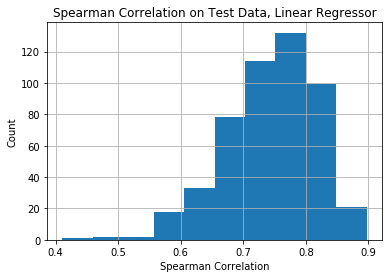

In [98]:
reg = reg_latent_cont('l',
                      states, states_test,
                      [.05, .25, .5, .75, .95],
                      svvol, svvol_test, burn_in,
                      id_traj=random.sample(range(n1), 50))

### Discrete Latent States

In [31]:
n1 = states[.5].shape[0]
n2 = states_test[.5].shape[0]

In [32]:
def clf_latent_disc(classifier,
                    states, states_test, quantiles_subset,
                    latent, latent_test, burn_in,
                    id_traj=random.sample(range(n1), 50),
                    fname=None):
    ''' Fit and predict states '''
    data = np.concatenate([states[q][id_traj]
                           for q in quantiles_subset], axis=2)
    data_test = np.concatenate([states_test[q]
                                for q in quantiles_subset], axis=2)
    p = data.shape[-1]
    
    print(f'data shape: {data.shape}')
    print(f'data_test shape: {data_test.shape}')
    
    # train
    if classifier.lower().startswith('l'):
        clf = LogisticRegression(C=1e8)
    else:
        clf = RandomForestClassifier(n_jobs=3, n_estimators=100,
                                     criterion='entropy')
        
    clf.fit(data[:, burn_in:, :].reshape((-1, p)),
            latent[id_traj, (burn_in + 1):].ravel())
    
    # test
    cross_entropy = [log_loss(g, clf.predict_proba(s))
                     for g, s in zip(latent_test[:, (burn_in + 1):],
                                     data_test[:, burn_in:, :])]
    
    plt.hist(cross_entropy)
    plt.grid()
    plt.xlabel('Cross Entropy')
    plt.ylabel('Count')
    plt.title('Cross Entropy on Test Data')
    # plt.savefig('doc/hist-ce-full-qtl.png')
    if fname is not None:
        plt.savefig(fname)
    
    return clf

data shape: (50, 999, 100)
data_test shape: (500, 999, 100)


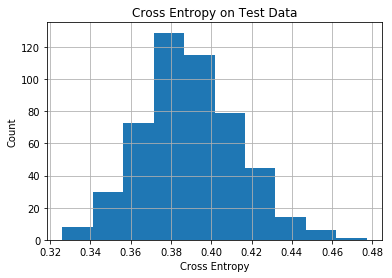

In [38]:
clf = clf_latent_disc('l',
                      states, states_test,
                      [.05, .25, .5, .75, .95],
                      rs_regime, rs_regime_test, burn_in,
                      id_traj=random.sample(range(n1), 50),
                      fname='doc/hist-ce-full-qtl.png')

If no regime-related information is provided, the high-vol state can only be identified 10% of time. It is possibly due to the fact that fitting high-variance variables take precedence over low-variance variables in regression.

In [36]:
__states_test = np.concatenate([states_test[q]
                                for q in [.05, .25, .5, .75, .95]], axis=2)
confusion_matrix(rs_regime_test[227, (burn_in + 1):],
                 clf.predict(__states_test[227, burn_in:, :]))

array([[622,  58],
       [ 58, 211]])

In [39]:
sess.close()